# Linear Regression Forecasting

-Essentially use regression to extrapolate a trend

-Basic assumption is that efficient markets hypothesis does not hold

In [5]:
import numpy as np
import pandas as pd

## Lagging Variables for Time-Series Forecasting

-It all depends on the number of lags you want to use

-If you want to use today's value, yesterday's and the day before's value then that is 3 lags

In [6]:
# Basic example
x = np.arange(12)
# if you want 3 lags then 0, 1, 2 are values of the independent variables
# while 3 would be the value of the dependent variable
# moving forward in time, then we would have 1,2,3 as independent variables
# and 4 as the dependent variable. The final combination is 8,9,10 and 11


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [17]:
lags = 3

# includes both independent and dependent variables
# hence the lags + 1. Then given a number of lags you can only
# use len(x) - lags of the time series
m = np.zeros((lags + 1, len(x) - lags))

# the dependent variable is then the time series starting at lags + 1
# but because python is zero indexed you implement it starting at lags
m[lags] = x[lags:]
for i in range(lags):
    # so here, for example on i = 0, you go to lags away from the end 
    # exclusive. so it would be -3 meaning the third from last (in this
    # case 9 but exclusive so up to 8). This is the ith row.
    m[i] = x[i:i - lags]

m.T

array([[ 0.,  1.,  2.,  3.],
       [ 1.,  2.,  3.,  4.],
       [ 2.,  3.,  4.,  5.],
       [ 3.,  4.,  5.,  6.],
       [ 4.,  5.,  6.,  7.],
       [ 5.,  6.,  7.,  8.],
       [ 6.,  7.,  8.,  9.],
       [ 7.,  8.,  9., 10.],
       [ 8.,  9., 10., 11.]])

In [19]:
reg = np.linalg.lstsq(m[:lags].T, m[lags], rcond=None)[0]
np.dot(m[:lags].T, reg)

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

## Predicting Index Levels

In [15]:
yo = np.arange(10)
yo.shape = (2,5)
print(f"This is the test array: {yo}")
print(f"When using one index for the numpy array: {yo[1]}")
# so one index just takes rows

This is the test array: [[0 1 2 3 4]
 [5 6 7 8 9]]
When using one index for the numpy array: [5 6 7 8 9]


In [22]:
# for the EUR/USD exchange rate
import yfinance as yf

[*********************100%***********************]  1 of 1 completed


C:\Users\Eddie\anaconda3\envs\securities-analysis\lib\site-packages\pandas\core\frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\Eddie\AppData\Local\Temp/ipykernel_20812/15442458.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data['price'].shift(lag)


<AxesSubplot:xlabel='Date'>

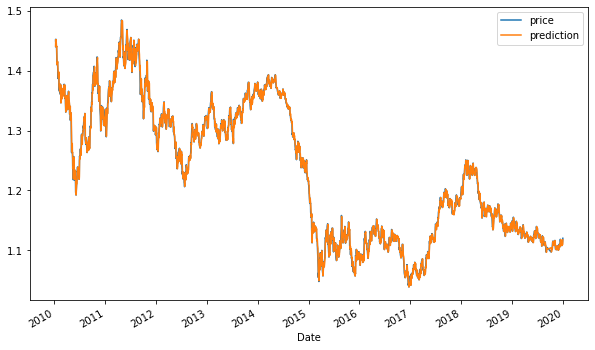

In [49]:
raw = yf.download("EURUSD=X",start="2010-01-04",end="2019-12-31")
raw.head()
data = raw[['Close']]
data.head()
data.rename(columns={'Close': 'price'}, inplace=True)

# now lag the time series to get the matrix of independent and 
# dependent variables.
# Keep in mind this is a forecast of today's price given lagged
# feature variables. If you want to forecast into the future, 
# you need to add features where the shift is performed in the 
# opposite direction. 
# see: https://machinelearningmastery.com/how-to-develop-deep-learning-models-for-univariate-time-series-forecasting/


lags = 5

cols = []
for lag in range(1, lags + 1):
    # this is for labelling the columns
    col = f'lag_{lag}'
    # simply create new columns which shift the time series by the lag
    data[col] = data['price'].shift(lag)
    # create list of column names to index them during the reg step
    cols.append(col)
data.dropna(inplace=True)

# This function solves data[cols] X = data['price']
reg = np.linalg.lstsq(data[cols], data['price'], rcond=None)[0]

reg

# esssentially this naiive forecast adds evidence to the random
# walk, that a prediction for today's price is yesterday's price.
# Because if you look at the coefficients, the first one (t-1 lag)
# is weighted the most

data['prediction'] = np.dot(data[cols], reg)

# plotting the forecast and the price, we can see how close they are
data[['price', 'prediction']].plot(figsize=(10,6))

<AxesSubplot:xlabel='Date'>

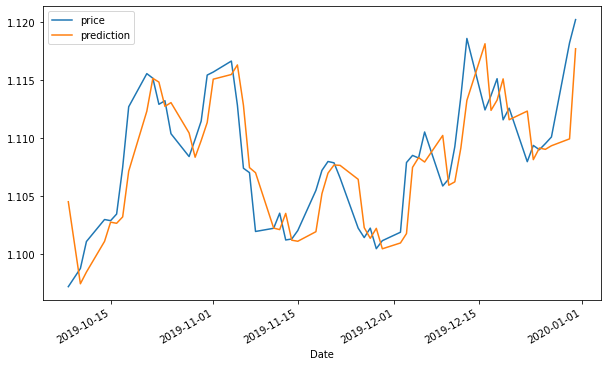

In [50]:
data[['price', 'prediction']].loc['2019-10-01':].plot(figsize=(10,6))

## Predicting the Log Returns EUR/USD

[*********************100%***********************]  1 of 1 completed


C:\Users\Eddie\anaconda3\envs\securities-analysis\lib\site-packages\pandas\core\frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\Eddie\AppData\Local\Temp/ipykernel_20812/3570506298.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['log_returns'] = (data['price'].pct_change() + 1).apply(np.log)
C:\Users\Eddie\AppData\Local\Temp/ipykernel_20812/3570506298.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

<AxesSubplot:xlabel='Date'>

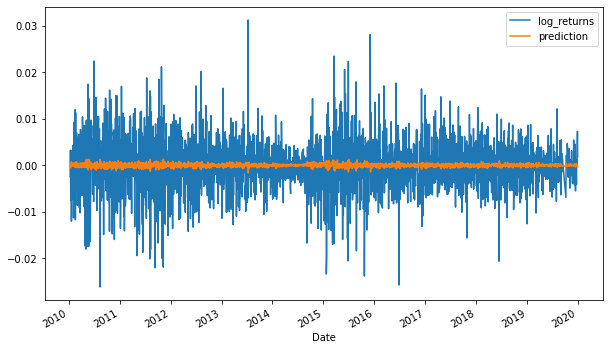

In [75]:
raw = yf.download("EURUSD=X",start="2010-01-04",end="2019-12-31")
raw.head()
data = raw[['Close']]
data.head()
data.rename(columns={'Close': 'price'}, inplace=True)

data['log_returns'] = (data['price'].pct_change() + 1).apply(np.log)

lags = 5
cols = []
# loop through lags, shift the time series and concatenate to dataframe

for lag in range(1,lags + 1):
    col = f"lag_{lag}"
    data[col] = data['log_returns'].shift(lag)
    cols.append(col)
data.dropna(inplace=True)

# Solve the linear matrix equation using least squares

reg = np.linalg.lstsq(data[cols], data['log_returns'], rcond=None)[0]
reg

data['prediction'] = np.dot(data[cols], reg)

data[['log_returns','prediction']].plot(figsize=(10,6))




## Try to Predict Direction of the Returns Instead

In [59]:
hits = np.sign(data['log_returns'] * data['prediction']).value_counts()

# hit ratio
hits.values[0] / sum(hits)
# this overestimates the hit ratio shown by hilpisch

0.5131987577639752

## Once again checking difference between yahoo finance and hilpisch dataset

In [87]:
raw = yf.download("EURUSD=X",start="2010-01-04",end="2019-12-31")
raw.head()
data = raw[['Close']]
data.head()
data.rename(columns={'Close': 'price'}, inplace=True)

raw_hilp = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',index_col=0, parse_dates=True).dropna() 
symbol = 'EUR='
data_hilp = pd.DataFrame(raw_hilp[symbol])
data_hilp.rename(columns={symbol: 'price'}, inplace=True)

data_hilp.head()
print(f"type of hilp datetime is: {type(data_hilp.index)}")
print(f"type of yahoo finance datetime is: {type(data[['price']].index)}")
data[(data_hilp.index.to_series() - data['price'].index.to_series()).isnull()].index
# THE DIFFERENCE IS HOLIDAYS!!!

[*********************100%***********************]  1 of 1 completed


C:\Users\Eddie\anaconda3\envs\securities-analysis\lib\site-packages\pandas\core\frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


type of hilp datetime is: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
type of yahoo finance datetime is: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


C:\Users\Eddie\AppData\Local\Temp/ipykernel_20812/4101689793.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[(data_hilp.index.to_series() - data['price'].index.to_series()).isnull()].index


DatetimeIndex(['2010-01-18', '2010-02-15', '2010-04-02', '2010-05-31',
               '2010-07-05', '2010-09-06', '2010-11-25', '2010-12-24',
               '2011-01-17', '2011-02-21', '2011-04-22', '2011-05-30',
               '2011-07-04', '2011-09-05', '2011-11-24', '2011-12-26',
               '2012-01-02', '2012-01-16', '2012-02-20', '2012-04-06',
               '2012-05-28', '2012-07-04', '2012-09-03', '2012-10-29',
               '2012-10-30', '2012-11-22', '2012-12-25', '2013-01-01',
               '2013-01-21', '2013-02-18', '2013-03-29', '2013-05-27',
               '2013-07-04', '2013-09-02', '2013-11-28', '2013-12-25',
               '2014-01-01', '2014-01-20', '2014-02-17', '2014-04-18',
               '2014-05-26', '2014-07-04', '2014-09-01', '2014-11-27',
               '2014-12-25', '2015-01-01', '2015-01-19', '2015-02-16',
               '2015-04-03', '2015-05-25', '2015-07-03', '2015-09-07',
               '2015-11-26', '2015-12-25', '2016-01-01', '2016-01-18',
      

## Now Regress on the sign 

In [104]:
raw = yf.download("EURUSD=X",start="2010-01-04",end="2019-12-31")
raw.head()
data = raw[['Close']]
data.head()
data.rename(columns={'Close': 'price'}, inplace=True)

data['log_returns'] = (data['price'].pct_change() + 1).apply(np.log)

lags = 5
cols = []
# loop through lags, shift the time series and concatenate to dataframe

for lag in range(1,lags + 1):
    col = f"lag_{lag}"
    data[col] = data['log_returns'].shift(lag)
    cols.append(col)
data.dropna(inplace=True)

# now regress on the SIGN of the log returns
reg = np.linalg.lstsq(data[cols], np.sign(data['log_returns']), rcond=None)[0]
reg

# now evaluate
# when making the prediction still take the sign
# because linear regression is shitty for classification tasks
data['predictions'] = np.sign(np.dot(data[cols], reg))

# then multiply these 1s and -1s with the log returns and once again
# take the sign to get the hit count
hits = np.sign(data['log_returns'] * data['predictions']).value_counts()

# hit ratio
hits.values[0] / sum(hits)

# observation: hit ratio appears to improve when using the sign of the log returns
# as the dependent variable

[*********************100%***********************]  1 of 1 completed


C:\Users\Eddie\anaconda3\envs\securities-analysis\lib\site-packages\pandas\core\frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\Eddie\AppData\Local\Temp/ipykernel_20812/2396965406.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['log_returns'] = (data['price'].pct_change() + 1).apply(np.log)
C:\Users\Eddie\AppData\Local\Temp/ipykernel_20812/2396965406.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

0.5221273291925466

## Backtest this forecast the sign of the log returns strategy

In [105]:
data.head()

,price,log_returns,lag_1,lag_2,lag_3,lag_4,lag_5,predictions
Date,,,,,,,,
2010-01-12,1.447660,-0.002391,0.006927,0.006478,-0.005989,0.002647,-0.004031,-1.0
2010-01-13,1.452391,0.003262,-0.002391,0.006927,0.006478,-0.005989,0.002647,-1.0
2010-01-14,1.449990,-0.001654,0.003262,-0.002391,0.006927,0.006478,-0.005989,-1.0
2010-01-15,1.439097,-0.007540,-0.001654,0.003262,-0.002391,0.006927,0.006478,1.0
2010-01-18,1.440673,0.001094,-0.007540,-0.001654,0.003262,-0.002391,0.006927,1.0


<AxesSubplot:xlabel='Date'>

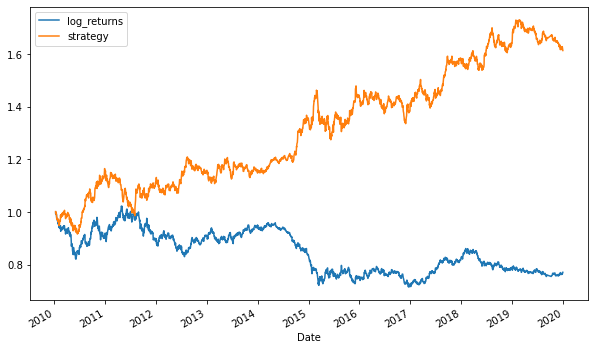

In [106]:
# recall that your prediction is essentially your long/short position, so multiple that by the log returns
# to get the 'strategy' column

data['strategy'] = data['predictions'] * data['log_returns']
data[['log_returns','strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10,6))

## Linear Regresion Vectorized Backtester Class

In [108]:
class LRVectorBacktester:
    '''
    a class for vectorized backtesting
    of a log-return sign linear regression
    strategy

    attributes
    ==========
    symbol: str
        the ticker symbol of the financial instrument 
        of interest
    start: str
        the start date of the history of interest
    end: str
        the end date of the history of interest
    amount: int, float
        initial investment 
    tc: float
        proportional transaction cost
    '''

    def __init__(self, symbol, start, end, amount, tc):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.amount = amount
        self.tc = tc
        self.results = None
        self.get_data()

    def get_data(self):
        raw = yf.download(self.symbol,start=self.start,end=self.end)
        data = raw[['Close']]
        data.rename(columns={'Close': 'price'}, inplace=True)
        data['log_returns'] = (data['price'].pct_change() + 1).apply(np.log)
        data.dropna(inplace=True)
        self.data = data

    def select_data(self, start, end):
        data = self.data[(self.data.index >= start) & (self.data.index <= end)].copy()
        return data

    def prepare_lags(self, start, end):
        data = self.select_data(start,end)
        lags = self.lags
        self.cols = []
        # loop through lags, shift the time series and concatenate to dataframe

        for lag in range(1,lags + 1):
            col = f"lag_{lag}"
            data[col] = data['log_returns'].shift(lag)
            self.cols.append(col)
        data.dropna(inplace=True)
        self.lagged_data = data

    def fit_model(self, start, end):
        # now regress on the SIGN of the log returns
        self.prepare_lags(start,end)
        reg = np.linalg.lstsq(self.lagged_data[self.cols], 
        np.sign(self.lagged_data['log_returns']), rcond=None)[0]
        self.reg = reg

    def run_strategy(self, start_in, end_in, start_out, end_out, lags=3):
        self.lags = lags
        # train on the training data
        self.fit_model(start_in,end_in)
        self.results = self.select_data(start_out,end_out)[self.lags:]
        self.prepare_lags(start_out, end_out)
        predictions = np.sign(np.dot(self.lagged_data[self.cols], self.reg))
        self.results['predictions'] = predictions
        self.results['strategy'] = self.results['predictions'] * \
            self.results['log_returns']
        trades = self.results['predictions'].diff().fillna(0) != 0
        self.results['strategy'][trades] -= self.tc
        self.results['creturns'] = self.amount * \
            self.results['log_returns'].cumsum().apply(np.exp)
        self.results['cstrategy'] = self.amount * \
            self.results['strategy'].cumsum().apply(np.exp)
        aperf = self.results['cstrategy'][-1]
        operf = aperf - self.results['creturns'][-1]
        return round(aperf,2), round(operf,2)

    def plot_returns(self):
        if self.results is None:
            print("No results to plot biiiiitches")
        self.results[['creturns', 'cstrategy']].plot(figsize=(10,6))

[*********************100%***********************]  1 of 1 completed


C:\Users\Eddie\anaconda3\envs\securities-analysis\lib\site-packages\pandas\core\frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\Eddie\AppData\Local\Temp/ipykernel_20812/2550024071.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['log_returns'] = (data['price'].pct_change() + 1).apply(np.log)
C:\Users\Eddie\anaconda3\envs\securities-analysis\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

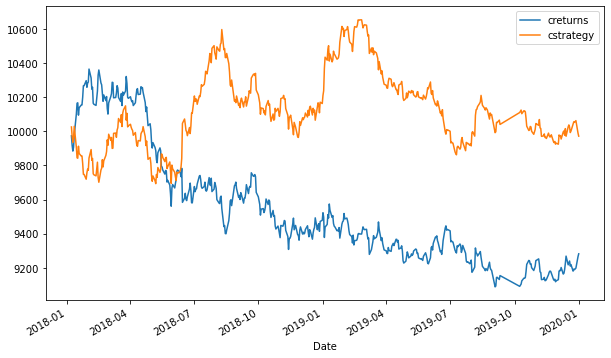

In [112]:
lrbt = LRVectorBacktester('EURUSD=X', '2010-01-01', '2019-12-31',10000, 0.0)

# not using a train, test split
lrbt.run_strategy('2010-01-01', '2019-12-31','2010-01-01', '2019-12-31', lags=5)

# using a train, test split
lrbt.run_strategy('2010-01-01', '2017-12-31','2018-01-01', '2019-12-31', lags=5)

lrbt.plot_returns()

[*********************100%***********************]  1 of 1 completed


C:\Users\Eddie\anaconda3\envs\securities-analysis\lib\site-packages\pandas\core\frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\Eddie\AppData\Local\Temp/ipykernel_20812/2550024071.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['log_returns'] = (data['price'].pct_change() + 1).apply(np.log)
C:\Users\Eddie\anaconda3\envs\securities-analysis\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

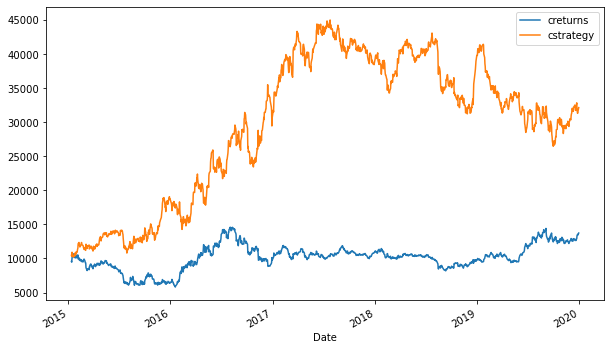

In [115]:
# consider GDX ETF

lrbt = LRVectorBacktester('GDX', '2010-01-01', '2019-12-31',10000, 0.002)

# no test set
lrbt.run_strategy('2010-01-01', '2019-12-31','2010-01-01', '2019-12-31', lags=7)

# test set of 4 years
lrbt.run_strategy('2010-01-01', '2014-12-31','2015-01-01', '2019-12-31', lags=7)

lrbt.plot_returns()